# CHAPTER 4.6

### Improving image resolution with deep learning

This notebook is prepared with the refence of the github repo of https://github.com/PacktPublishing/Tensorflow-2.0-Computer-Vision-Cookbook/tree/master/ch4/recipe6. You can find detailed info and codes explanation from the book.

Convolutional Neural Networks (CNNs) can also be used to improve the resolution of low-quality images. Historically, we can achieve this by using interpolation techniques, example-based approaches, or low- to high-resolution mappings that must be learned.

In [1]:
import pathlib
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tensorflow.keras import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import *

We will apply some preprocess and possprocess on images... before building our model or prepare our functions, firstl I will apply this processes to an example image to understand code easily

In [ ]:
#for resize process, we will take a scale factor and resize image with it


In [17]:
image_path='dogs_4CNN.jpg'
#load image
image = load_img(image_path)
#define factor for scaling
print('original image size {}'.format(image.size))
factor=2
#calculate new image size by multiply factor and origin size
new_size = np.array(image.size) * factor
new_size = new_size.astype(np.int32)


original image size (916, 515)


In [19]:
print(new_size)

[1832 1030]


In [20]:
new_size = tuple(new_size)
print(new_size)

(1832, 1030)


In [21]:
#now resize image and convert it to array
resized = image.resize(new_size)
resized = img_to_array(resized)
resized = resized.astype(np.uint8)

In [22]:
resized.shape

(1030, 1832, 3)

In [23]:
#this all process will be in function as :
def resize_image(image_array, factor):
    original_image = Image.fromarray(image_array)
    new_size = np.array(original_image.size) * factor
    new_size = new_size.astype(np.int32)
    new_size = tuple(new_size)

    resized = original_image.resize(new_size)
    resized = img_to_array(resized)
    resized = resized.astype(np.uint8)

    return resized

We will tightly crop an image. We are doing this because we want the image to fit nicely when we apply a sliding window to extract patches later.

In [26]:
image_path='dogs_4CNN.jpg'
#load image
image = load_img(image_path)
image = img_to_array(image)
image = image.astype(np.uint8)
height, width = image.shape[:2]
print('height is {}'.format(height))
print('width is {}'.format(width))

height is 515
width is 916


In [27]:
width -= int(width % factor)
height -= int(height % factor)
print('height is {}'.format(height))
print('width is {}'.format(width))
# and we will crop image with these dimensions

height is 514
width is 916


In [28]:
#This process will be in fuction as : 
def tight_crop_image(image):
    height, width = image.shape[:2]
    width -= int(width % SCALE)
    height -= int(height % SCALE)

    return image[:height, :width]

we will purposely reduce the resolution of an image by downsizing it and then upsizing it. for this purpose we will use this funciton :


In [29]:
def downsize_upsize_image(image):
    scaled = resize_image(image, 1.0 / SCALE)
    scaled = resize_image(scaled, SCALE / 1.0)

    return scaled

we will crop patches from input and output images according to their dimensions.

In [30]:
def crop_input(image, x, y):
    y_slice = slice(y, y + INPUT_DIM)
    x_slice = slice(x, x + INPUT_DIM)

    return image[y_slice, x_slice]


def crop_output(image, x, y):
    y_slice = slice(y + PAD, y + PAD + LABEL_SIZE)
    x_slice = slice(x + PAD, x + PAD + LABEL_SIZE)

    return image[y_slice, x_slice]

Now we will prepare our dataset from dog and cats datasets(https://www.kaggle.com/andrewmvd/dog-and-cat-detection). As a supervised learning we will load them in as data and labels

In [31]:
SEED = 999
np.random.seed(SEED)
SUBSET_SIZE = 1500
file_patten = (pathlib.Path.home() / '.keras' / 'datasets' /
               'dogscats' / 'images' / '*.png')
file_pattern = str(file_patten)
dataset_paths = [*glob(file_pattern)]
dataset_paths = np.random.choice(dataset_paths, SUBSET_SIZE)

In [32]:
len(dataset_paths)

1500

we have 1500 images in our file. 

In [33]:
SCALE = 2.0
INPUT_DIM = 33
LABEL_SIZE = 21
PAD = int((INPUT_DIM - LABEL_SIZE) / 2.0)
STRIDE = 14

In [34]:
data = []
labels = []
for image_path in dataset_paths:
    image = load_img(image_path)
    image = img_to_array(image)
    image = image.astype(np.uint8)

    image = tight_crop_image(image)
    scaled = downsize_upsize_image(image)

    height, width = image.shape[:2]

    for y in range(0, height - INPUT_DIM + 1, STRIDE):
        for x in range(0, width - INPUT_DIM + 1, STRIDE):
            crop = crop_input(scaled, x, y)
            target = crop_output(image, x, y)

            data.append(crop)
            labels.append(target)

data = np.array(data)
labels = np.array(labels)

we created our data and labels from our images by cropping them. Let's check what we have

In [35]:
print('data array shape is {}'.format(data.shape)) 
print('labels array shape is {}'.format(labels.shape)) 

data array shape is (1065565, 33, 33, 3)
labels array shape is (1065565, 21, 21, 3)


We have two arrays with same 1065565 images with different sizes.

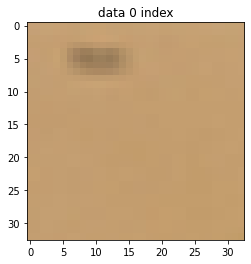

In [39]:
original_image = Image.fromarray(data[0])
plt.title('data 0 index')
plt.imshow(original_image)
plt.show()

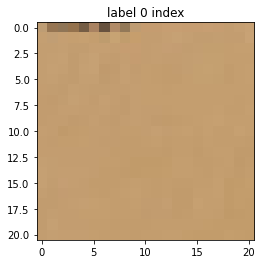

In [40]:
label_image = Image.fromarray(labels[0])
plt.title('label 0 index')
plt.imshow(label_image)
plt.show()

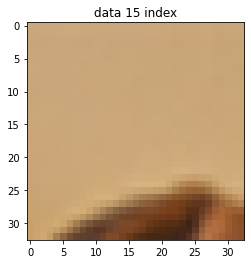

In [45]:
original_image = Image.fromarray(data[15])
plt.title('data 15 index')
plt.imshow(original_image)
plt.show()

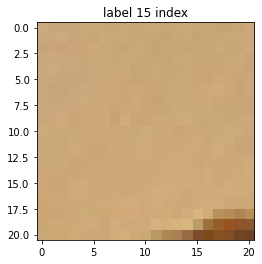

In [46]:
label_image = Image.fromarray(labels[15])
plt.title('label 15 index')
plt.imshow(label_image)
plt.show()

Now we will buil our CNN model and fit it with our dataset

In [47]:
def build_srcnn(height, width, depth):
    input = Input(shape=(height, width, depth))

    x = Conv2D(filters=64, kernel_size=(9, 9),
               kernel_initializer='he_normal')(input)
    x = ReLU()(x)
    x = Conv2D(filters=32, kernel_size=(1, 1),
               kernel_initializer='he_normal')(x)
    x = ReLU()(x)
    output = Conv2D(filters=depth, kernel_size=(5, 5),
                    kernel_initializer='he_normal')(x)

    return Model(input, output)

In [48]:
EPOCHS = 12

optimizer = Adam(lr=1e-3, decay=1e-3 / EPOCHS)
model = build_srcnn(INPUT_DIM, INPUT_DIM, 3)
model.compile(loss='mse', optimizer=optimizer)

C:\Users\Zeki\anaconda3\envs\githubtf\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


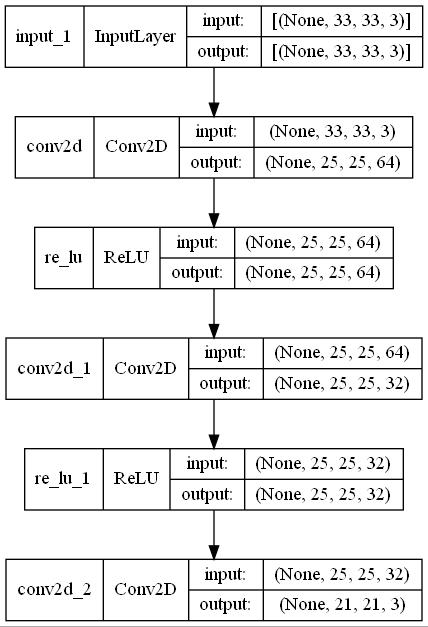

In [49]:
from tensorflow.keras.utils import plot_model
from PIL import Image
plot_model(model, show_shapes=True, show_layer_names=True, to_file='my_CNN_superres_4thnotebook.jpg')

In [50]:
BATCH_SIZE = 64
model.fit(data, labels, batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/12
16650/16650 [==============================] - 100s 5ms/step - loss: 102.1841
Epoch 2/12
16650/16650 [==============================] - 95s 6ms/step - loss: 86.9891
Epoch 3/12
16650/16650 [==============================] - 95s 6ms/step - loss: 85.4866
Epoch 4/12
16650/16650 [==============================] - 94s 6ms/step - loss: 84.7378
Epoch 5/12
16650/16650 [==============================] - 96s 6ms/step - loss: 84.2688
Epoch 6/12
16650/16650 [==============================] - 94s 6ms/step - loss: 83.9656
Epoch 7/12
16650/16650 [==============================] - 95s 6ms/step - loss: 83.7494
Epoch 8/12
16650/16650 [==============================] - 97s 6ms/step - loss: 83.5785
Epoch 9/12
16650/16650 [==============================] - 94s 6ms/step - loss: 83.4462
Epoch 10/12
16650/16650 [==============================] - 92s 6ms/step - loss: 83.3358
Epoch 11/12
16650/16650 [==============================] - 93s 6ms/step - loss: 83.2437
Epoch 12/12
16650/16650 [==============

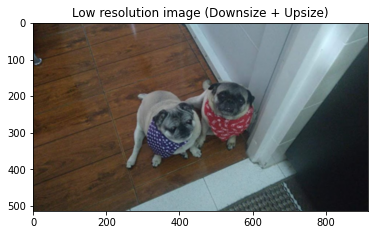

In [85]:
# Test on image
image = load_img('dogs_4CNN.jpg')
image = img_to_array(image)
image = image.astype(np.uint8)

image = tight_crop_image(image)
scaled = downsize_upsize_image(image)

plt.title('Low resolution image (Downsize + Upsize)')
plt.imshow(scaled)
plt.show()
output_1=scaled.astype('uint8')
plt.imsave('result4_bicubic.png',output_1)

We will take batches and try to resize it without losing data. Because of that , we take a batch from input and predict model new sized array

In [52]:
model.save('cnn_superres_4th')

INFO:tensorflow:Assets written to: cnn_superres_4th\assets


In [66]:
output = np.zeros(scaled.shape)
height, width = output.shape[:2]

for y in range(0, height - INPUT_DIM + 1, LABEL_SIZE):
    for x in range(0, width - INPUT_DIM + 1, LABEL_SIZE):
        crop = crop_input(scaled, x, y)

        image_batch = np.expand_dims(crop, axis=0)
        prediction = model.predict(image_batch)
        new_shape = (LABEL_SIZE, LABEL_SIZE, 3)
        prediction = prediction.reshape(new_shape)

        output_y_slice = slice(y + PAD, y + PAD + LABEL_SIZE)
        output_x_slice = slice(x + PAD, x + PAD + LABEL_SIZE)
        output[output_y_slice, output_x_slice] = prediction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


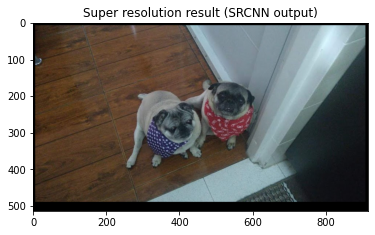

In [67]:
plt.title('Super resolution result (SRCNN output)')
plt.imshow(output / 255)
plt.show()


Be careful about datatype for saving !!!

In [86]:
print(output.dtype)

float64


In [81]:
output_2=output.astype('uint8')

In [84]:
plt.imsave('result4_pillow.png',output_2)

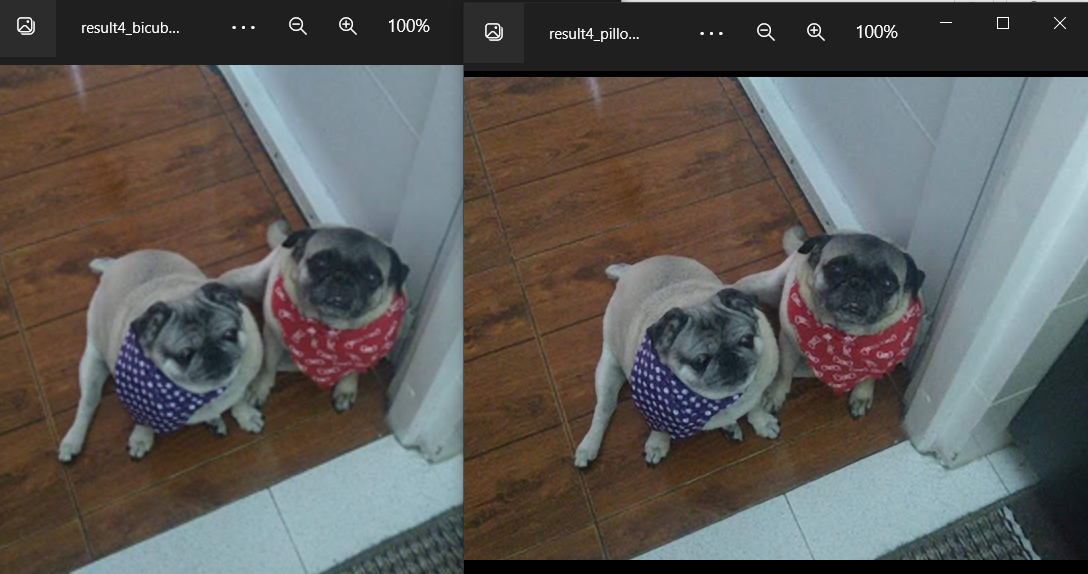

As you can see right image is sharper and has better details 